In [1]:
library(TreePar)
library(TreeSim)
library(NELSI)
library(doParallel)
library(foreach)

Loading required package: ape
Loading required package: Matrix
Loading required package: subplex
Loading required package: TreeSim
Loading required package: laser
Loading required package: geiger
Loading required package: deSolve

Attaching package: ‘deSolve’

The following object is masked from ‘package:graphics’:

    matplot

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


## Diversification model adequacy: constant rates

In this trivial example. I simulate a ten trees under constant speciation and extinction rates. I refer to these as 'empirical' trees. I fit a rate shift model to estimate speciation and extinction rates for 0 rate shifts (i.e. constant rates). Using the speciation ($\lambda$) and extiction ($\mu$) rate estimates from this model, I simulate a 100 trees without rate shifts . For each simulated tree, I find the maximum likelihood under the model used to generate them (that with 0 rate shifts), resulting in a null distribution of the likelihood, under the 'correct' model. I calculate the *P* value of the likelihood of the 'reference' tree under the null likelihood distribution for the model.

- Simulate a birth-death tree with 100 taxa, with 0.5 sampling at present.

In [2]:
set.seed(1234)
nspecies <- 100
rho <- 0.5
lambda <- 3
mu <- 1.5

constant_rates_trees <- sim.bd.taxa(n = nspecies, numbsim = 10, lambda = lambda, mu = mu, frac = rho, complete = F)


- This function fits a rate shifts model with up to two rate changes, and returns $\lambda$ and $\mu$, calculated from the turnover and net speciation rate for different numbers of rate shifts. In this example I am only using one rate shift.

In [3]:
fit_rate_shifts <- function(tree, rho){ # Rho at present.

    x_times <- sort(intnode.times(tree), decreasing = T)
    start <- min(x_times)
    end <- max(x_times)
    grid <- diff(range(x_times))
    res <- bd.shifts.optim(x_times, c(rho, 1, 1), grid, start, end, posdiv = T)[[2]]

    # Find likelihoods, lambda, mu, and rate-shift times
    likelihoods <- sapply(res, function(x) x[1]) 
    
    lambda0 <- res[[1]][3] / (1 - res[[1]][2]) # These are the lambda and mu estimates from turover and net 
    mu0 <- lambda0 * res[[1]][2]               # speciation for 0 rate shifts. Please check.
   
    # The following are also computed, but note that some of them are negative and that this might. 
    # I couldn't simulate trees using these parameters, maybe because of the negative values?
    lambda11 <- res[[2]][3] / (1 - res[[2]][2])
    mu11 <- lambda11 * res[[2]][2]
    lambda12 <- res[[2]][5] / (1 - res[[2]][4])
    mu12 <- lambda12 * res[[2]][4]
    time1 <- res[[2]][length(res[[2]])]
        
    lambda21 <- res[[3]][3] / (1 - res[[3]][2])
    mu21 <- lambda21 * res[[2]][2]
    lambda22 <- res[[3]][5] / (1 - res[[3]][4])
    mu22 <- lambda22 * res[[3]][4]
    lambda23 <- res[[3]][7] / (1 - res[[3]][6])
    mu23 <- lambda23 * res[[3]][6]
    time2 <- res[[3]][(length(res[[3]]) - 2):length(res[[3]])]
    
    return(list(likelihoods, shifts0= c(lambda0, mu0), shifts1=c(lambda11, lambda12, mu11, mu12, time1), 
               shifts2=c(lambda21, lambda22, lambda23, mu21, mu22, mu23, time2)))
}

- In the followig loop, I iterate through all the 'emprical' trees. For each tree, I estimate $\lambda$ and $\mu$. I then use these values to simulate 100 trees. For each simulated tree I calculate the maximum likelihood to use as a null distribution.

In [12]:
pvals <- vector()
likelihoods_distros <- list()
likelihoods_empirical <- vector()
empirical_tree_param_estimates <- list()

cl <- makeCluster(8)
registerDoParallel(cl)
for(tr in 1:length(constant_rates_trees)){
    x_times <- sort(intnode.times(constant_rates_trees[[tr]]), decreasing = T)
    start <- min(x_times)
    end <- max(x_times)
    grid <- diff(range(x_times))
    
    reference_estimates <- fit_rate_shifts(constant_rates_trees[[tr]], 0.5)

    sim_trees0 <- sim.bd.taxa(n = nspecies, numbsim = 100, lambda = reference_estimates$shifts0[1], 
                              mu = reference_estimates$shifts0[2], frac = 0.5, complete = F)
    liks_sim_trees0 <- foreach(mt = sim_trees0, .packages = c('NELSI', 'TreePar')) %dopar% fit_rate_shifts(mt, 1)[[1]][1]
    likelihoods_distros[[tr]] <- liks_sim_trees0
    likelihoods_empirical[tr] <- reference_estimates[[1]][1]
    empirical_tree_param_estimates[[tr]] <- reference_estimates$shifts0
    pvals[tr] <- sum(reference_estimates[[1]][1] > liks_sim_trees0)

}
stopCluster(cl)

[1] "startest"
[1] "test"
[1] 1.000000000 0.007664533
[1] 6.149162e+01 5.083584e-05 2.598717e-01 2.609607e+00 1.736571e+00
[6] 7.664533e-03
[1] 1.000000 2.416421
[1] 61.498913  0.270048  0.270048  1.731035  1.731035  2.416421
[[1]]
[1] 61.498913  0.270048  1.731035

[[2]]
[1] 6.149162e+01 5.083584e-05 2.598717e-01 2.609607e+00 1.736571e+00
[6] 7.664533e-03

[1] 2.000000 2.416421
[1] 6.149161e+01 1.539627e-05 2.596761e-01 3.561468e-01 2.613520e+00
[6] 1.736061e+00 2.056018e+00 7.664533e-03 2.416421e+00
[[1]]
[1] 61.498913  0.270048  1.731035

[[2]]
[1] 6.149162e+01 5.083584e-05 2.598717e-01 2.609607e+00 1.736571e+00
[6] 7.664533e-03

[[3]]
[1] 6.149161e+01 1.539627e-05 2.596761e-01 3.561468e-01 2.613520e+00
[6] 1.736061e+00 2.056018e+00 7.664533e-03 2.416421e+00

[1] "startest"
[1] "test"
[1] 1.000000000 0.003952441
[1] 63.088774624  0.019778413  0.458081292  4.979402918  1.472523864
[6]  0.003952441
[1] 1.0000 2.9533
[1] 63.2442632  0.4769843  0.5252916  1.4587133  1.5085546  2.9532997

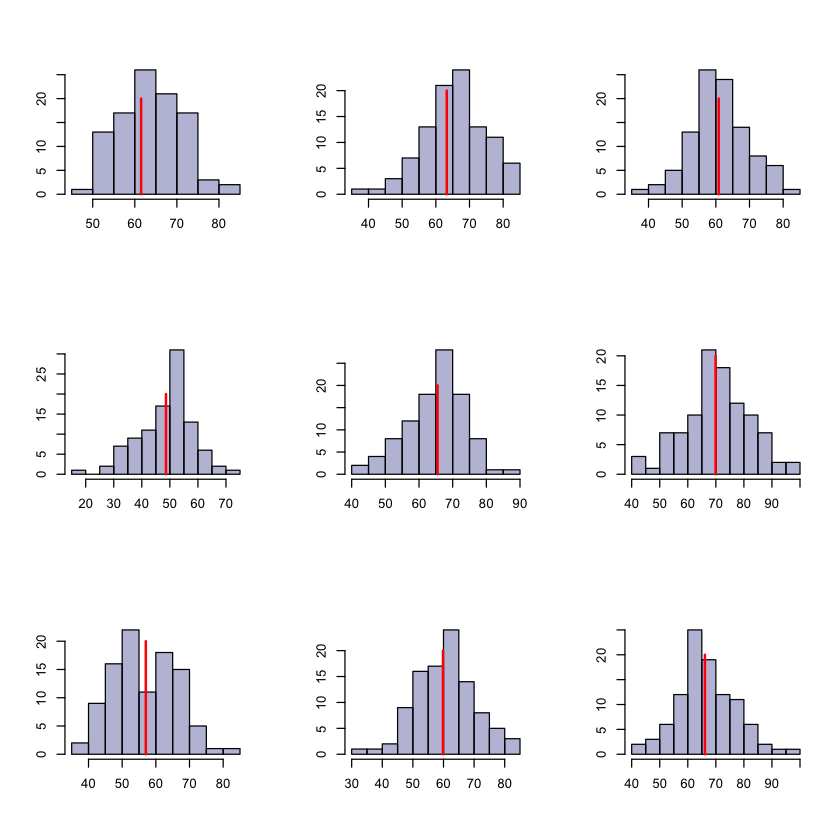

In [29]:
par(mfrow = c(3, 3))
for(i in 1:9){
    hist(as.numeric(likelihoods_distros[[i]]), main = '', ylab = '', xlab = '', col = rgb(0, 0, 0.5, 0.3))
    lines(x = c(likelihoods_empirical[i], likelihoods_empirical[i]), y = c(0, 20), col = 'red', lwd = 2)
}

**Figure 1.** The histograms correspond to the likelihoods of the simulated trees. The red vertical line is the likelihood of the 'empirical' tree.

- The *P* values are: 

In [44]:
pvals/100

[1] 0.36 0.37 0.51 0.46 0.51 0.47 0.53 0.43 0.50 0.51

- For comparisson, these are the $\lambda$ and $\mu$ estimates from the 'empirical trees. Recall the the true values are; $\lambda$ = 3, and $\mu$ = 1.5.

In [45]:
param_estimates <- t(data.frame(empirical_tree_param_estimates))
rownames(param_estimates) <- paste0('empirical_tree', 1:nrow(param_estimates))
colnames(param_estimates) <- c('lambda', 'mu')
param_estimates

,lambda,mu
empirical_tree1,2.3714367,0.6404019
empirical_tree2,2.788231,1.328501
empirical_tree3,2.3981704,0.6271396
empirical_tree4,3.112596,1.356555
empirical_tree5,2.791010,1.399821
empirical_tree6,2.987332,1.821800
empirical_tree7,3.186681,1.743237
empirical_tree8,3.987820,2.976782
empirical_tree9,2.672509,1.234840
empirical_tree10,3.700232,2.475870
